In [30]:
# Import dependencies
import nibabel as nib
import numpy as np
import cv2
import scipy.io
import os
import imageio
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
from utils import *
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import ndimage
import random
from mayavi import mlab
import pandas as pd
sys.path.append("..")
from utils_l import *


# DATA

In [31]:
def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

In [32]:
def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 64
    desired_height = 64
    
    # Compute depth factor
    f0 = desired_width /  img.shape[0]
    f1 = desired_height /  img.shape[1]
    f2 = desired_depth /   img.shape[2]

    img = ndimage.zoom(img, (f0, f1, f2), order=1)
    return img, f0, f1,f2

In [33]:
def process_study(path):
    """Read and resize volume"""
    
    ct_path = os.path.join(path, "preop_ct.nii")
    pins_path =  os.path.join(path, "pin_tips.npy")
    
    nifti = nib.load(ct_path)
    nifti_data = np.nan_to_num(np.array(nifti.get_fdata()))
    coords = np.load(pins_path)
    coords = from_hull_to_ct_coords(coords, nifti).squeeze()    
    # Normalize
    volume = normalize(nifti_data)
    # Resize width, height and depth
    volume, f0, f1, f2 = resize_volume(volume)
    
    coords[:,0]*=f0
    coords[:,1]*=f1
    coords[:,2]*=f2
    
    coords = sort_points_by_distance_from_origin(coords)
    
    return volume, coords, [f0,f1,f2]

In [34]:
DATA_PATH = "C:/Users/VukadinoviM/Documents/BrainReg/data"
study_paths = []
study_names = []
for study in os.listdir(DATA_PATH):
    if (os.path.exists(os.path.join(DATA_PATH, study, "preop_ct.nii")) and  
       os.path.exists(p:= os.path.join(DATA_PATH, study, "pin_tips.npy")) and
       np.load(p).shape[0]==4):
        study_paths.append(os.path.join(DATA_PATH, study))
        study_names.append(study)

1. Sort study_names based on split 
2. In split exclude the ones not present in study names
3. Take length(train) of it

In [35]:
import pandas as pd
df = pd.read_csv("../split.csv")
study_names=np.array(study_names)

In [36]:
# drop missing
df_ids = df.ids
to_keep = []
for i, idx in enumerate(df_ids):
    if idx in study_names:
        to_keep.append(i)
df = df.loc[df['Unnamed: 0'].isin(to_keep)]
train_size = np.sum(df['split']=="train")
df_ids = df.ids
# get indices of study names in ids
sort_ids=[]
for idx in df_ids:
    sort_ids.append(np.where(study_names == idx)[0][0])

WARNING: DON'T RUN THE FOLLOWIN CELL TWICE!

In [37]:
study_names = study_names[sort_ids]
study_paths = np.array(study_paths)[sort_ids]

In [38]:
scans = [] 
labels = []

for path in study_paths:
    s,l,_ = process_study(path)
    scans.append(s)
    labels.append(l)
    
scans = np.array(scans)
labels = np.array(labels)

In [39]:
x_train=scans[:train_size]
y_train=labels[:train_size]

x_val=scans[train_size:]
y_val=labels[train_size:]

In [40]:
x_train.shape

(60, 64, 64, 64)

In [41]:
y_train.shape

(60, 4, 3)

In [42]:
x_val.shape

(16, 64, 64, 64)

In [43]:
y_val.shape

(16, 4, 3)

### INSERT DATA AUGMENTATION

In [44]:
import random
import tensorflow_addons as tfa
def rotation_M(angle, axis):
    if axis=='x':
        Mx = np.array([[1,0,0],
                       [0, np.cos(angle), -np.sin(angle)],
                       [0, np.sin(angle), np.cos(angle)]])
        return Mx
    elif axis=='y':
        My = np.array([[np.cos(angle), 0, np.sin(angle)],
                      [0, 1, 0],
                      [-np.sin(angle), 0, np.cos(angle)]])
        return My
    elif axis=='z':
        Mz = np.array([[np.cos(angle), -np.sin(angle), 0],
                       [np.sin(angle), np.cos(angle), 0],
                       [0, 0, 1]])
        return Mz
    elif axis=='2':
        M2 = np.array([[np.cos(angle), -np.sin(angle)],
               [np.sin(angle), np.cos(angle)]])
        return M2
@tf.function
def rotate_img(volume, label):
    """Rotate the volume by a few degrees"""
    print(volume.shape)
    def scipy_rotate(volume,angle):

        
        #rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume<0]=0
        volume[volume>1]=1
        return volume
    
    # define some rotation angles
    angles = [-20, -10, -5, 5, 10, 20]
    # pick angles at random
    angle=random.choice(angles)
    # augment volume
    augmented_volume = tf.numpy_function(scipy_rotate, [volume, angle], tf.float32)
    #augment labels
    radian_angle = angle*np.pi/180
    # make the center of the image center of rotation
    x_center = volume.shape[0]/2
    y_center = volume.shape[1]/2
    centering_mat =  tf.cast(tf.constant(np.array([[x_center,y_center,0],
                                              [x_center,y_center,0],
                                              [x_center,y_center,0],
                                              [x_center,y_center,0]])),
                                                dtype=tf.float64)
    
    aligned_label = label - centering_mat
    
    rot_m = tf.cast(tf.constant(rotation_M(radian_angle, 'z')),dtype=tf.float64)
    
    aug_label = tf.linalg.matmul(aligned_label, tf.transpose(rot_m)) + centering_mat

    return augmented_volume, aug_label

In [54]:
def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    #if np.random.random(1)[0] < 0.2:
    #    volume, mask = rotate_img(volume,label)
    volume = tf.expand_dims(volume, axis=3)
    #Normalize labels
    label = tf.divide(label, 60)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)

    #Normalize labels
    label = tf.divide(label, 60)
    return volume, label

In [55]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [56]:
batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

# MODEL

In [57]:
def get_model(width=64, height=64, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(units=12, activation="sigmoid")(x)
    out = layers.Reshape((4,3))(x)
    
    # Define the model.
    model = keras.Model(inputs, out, name="3dcnn")
    return model


# Build model.
model = get_model(width=64, height=64, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 64, 1)]   0         
                                                                 
 conv3d_4 (Conv3D)           (None, 62, 62, 62, 64)    1792      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 31, 31, 31, 64)   0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 31, 31, 31, 64)   256       
 hNormalization)                                                 
                                                                 
 conv3d_5 (Conv3D)           (None, 29, 29, 29, 64)    110656    
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 14, 14, 14, 64)   0     

In [58]:
# Compile model.
initial_learning_rate = 0.0001

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=EuclideanDistance(),
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)

#early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 400
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb] #early_stopping_cb],
)

Epoch 1/400
30/30 - 3s - loss: 0.0518 - ed: 0.1906 - val_loss: 0.0377 - val_ed: 0.1633 - 3s/epoch - 109ms/step
Epoch 2/400
30/30 - 2s - loss: 0.0325 - ed: 0.1485 - val_loss: 0.0162 - val_ed: 0.0918 - 2s/epoch - 77ms/step
Epoch 3/400
30/30 - 2s - loss: 0.0192 - ed: 0.1097 - val_loss: 0.0157 - val_ed: 0.0794 - 2s/epoch - 78ms/step
Epoch 4/400
30/30 - 2s - loss: 0.0124 - ed: 0.0857 - val_loss: 0.0237 - val_ed: 0.1104 - 2s/epoch - 76ms/step
Epoch 5/400
30/30 - 2s - loss: 0.0116 - ed: 0.0826 - val_loss: 0.0321 - val_ed: 0.1364 - 2s/epoch - 76ms/step
Epoch 6/400
30/30 - 2s - loss: 0.0110 - ed: 0.0813 - val_loss: 0.0439 - val_ed: 0.1656 - 2s/epoch - 76ms/step
Epoch 7/400
30/30 - 2s - loss: 0.0071 - ed: 0.0651 - val_loss: 0.0488 - val_ed: 0.1760 - 2s/epoch - 79ms/step
Epoch 8/400
30/30 - 3s - loss: 0.0068 - ed: 0.0638 - val_loss: 0.0451 - val_ed: 0.1684 - 3s/epoch - 85ms/step
Epoch 9/400
30/30 - 3s - loss: 0.0076 - ed: 0.0674 - val_loss: 0.0476 - val_ed: 0.1724 - 3s/epoch - 86ms/step
Epoch 10/

Epoch 75/400
30/30 - 3s - loss: 0.0020 - ed: 0.0358 - val_loss: 0.0127 - val_ed: 0.0618 - 3s/epoch - 84ms/step
Epoch 76/400
30/30 - 3s - loss: 0.0017 - ed: 0.0326 - val_loss: 0.0140 - val_ed: 0.0681 - 3s/epoch - 84ms/step
Epoch 77/400
30/30 - 3s - loss: 0.0016 - ed: 0.0317 - val_loss: 0.0141 - val_ed: 0.0687 - 3s/epoch - 84ms/step
Epoch 78/400
30/30 - 3s - loss: 0.0017 - ed: 0.0325 - val_loss: 0.0140 - val_ed: 0.0676 - 3s/epoch - 84ms/step
Epoch 79/400
30/30 - 3s - loss: 0.0039 - ed: 0.0383 - val_loss: 0.0128 - val_ed: 0.0608 - 3s/epoch - 84ms/step
Epoch 80/400
30/30 - 3s - loss: 0.0019 - ed: 0.0343 - val_loss: 0.0152 - val_ed: 0.0749 - 3s/epoch - 85ms/step
Epoch 81/400
30/30 - 3s - loss: 0.0019 - ed: 0.0340 - val_loss: 0.0172 - val_ed: 0.0818 - 3s/epoch - 84ms/step
Epoch 82/400
30/30 - 3s - loss: 0.0019 - ed: 0.0333 - val_loss: 0.0227 - val_ed: 0.1049 - 3s/epoch - 84ms/step
Epoch 83/400
30/30 - 3s - loss: 0.0017 - ed: 0.0326 - val_loss: 0.0180 - val_ed: 0.0863 - 3s/epoch - 84ms/step
E

Epoch 149/400
30/30 - 3s - loss: 9.2442e-04 - ed: 0.0238 - val_loss: 0.0131 - val_ed: 0.0616 - 3s/epoch - 85ms/step
Epoch 150/400
30/30 - 3s - loss: 0.0011 - ed: 0.0260 - val_loss: 0.0132 - val_ed: 0.0608 - 3s/epoch - 85ms/step
Epoch 151/400
30/30 - 3s - loss: 0.0010 - ed: 0.0253 - val_loss: 0.0117 - val_ed: 0.0547 - 3s/epoch - 86ms/step
Epoch 152/400
30/30 - 3s - loss: 9.5600e-04 - ed: 0.0244 - val_loss: 0.0117 - val_ed: 0.0557 - 3s/epoch - 85ms/step
Epoch 153/400
30/30 - 3s - loss: 0.0011 - ed: 0.0258 - val_loss: 0.0132 - val_ed: 0.0625 - 3s/epoch - 85ms/step
Epoch 154/400
30/30 - 3s - loss: 0.0010 - ed: 0.0249 - val_loss: 0.0111 - val_ed: 0.0514 - 3s/epoch - 85ms/step
Epoch 155/400
30/30 - 3s - loss: 0.0011 - ed: 0.0260 - val_loss: 0.0119 - val_ed: 0.0570 - 3s/epoch - 85ms/step
Epoch 156/400
30/30 - 3s - loss: 0.0018 - ed: 0.0268 - val_loss: 0.0116 - val_ed: 0.0550 - 3s/epoch - 85ms/step
Epoch 157/400
30/30 - 3s - loss: 0.0017 - ed: 0.0284 - val_loss: 0.0121 - val_ed: 0.0574 - 3s/ep

Epoch 221/400
30/30 - 3s - loss: 8.0437e-04 - ed: 0.0221 - val_loss: 0.0120 - val_ed: 0.0582 - 3s/epoch - 85ms/step
Epoch 222/400
30/30 - 3s - loss: 8.3426e-04 - ed: 0.0226 - val_loss: 0.0110 - val_ed: 0.0528 - 3s/epoch - 87ms/step
Epoch 223/400
30/30 - 3s - loss: 7.9714e-04 - ed: 0.0220 - val_loss: 0.0122 - val_ed: 0.0589 - 3s/epoch - 87ms/step
Epoch 224/400
30/30 - 3s - loss: 7.9421e-04 - ed: 0.0217 - val_loss: 0.0099 - val_ed: 0.0477 - 3s/epoch - 87ms/step
Epoch 225/400
30/30 - 3s - loss: 8.4082e-04 - ed: 0.0226 - val_loss: 0.0104 - val_ed: 0.0490 - 3s/epoch - 84ms/step
Epoch 226/400
30/30 - 3s - loss: 9.2106e-04 - ed: 0.0237 - val_loss: 0.0103 - val_ed: 0.0486 - 3s/epoch - 84ms/step
Epoch 227/400
30/30 - 3s - loss: 8.1249e-04 - ed: 0.0216 - val_loss: 0.0102 - val_ed: 0.0470 - 3s/epoch - 84ms/step
Epoch 228/400
30/30 - 2s - loss: 8.1132e-04 - ed: 0.0218 - val_loss: 0.0161 - val_ed: 0.0809 - 2s/epoch - 83ms/step
Epoch 229/400
30/30 - 3s - loss: 6.8155e-04 - ed: 0.0204 - val_loss: 0.0

Epoch 292/400
30/30 - 3s - loss: 7.1784e-04 - ed: 0.0205 - val_loss: 0.0115 - val_ed: 0.0543 - 3s/epoch - 86ms/step
Epoch 293/400
30/30 - 3s - loss: 6.6414e-04 - ed: 0.0198 - val_loss: 0.0114 - val_ed: 0.0535 - 3s/epoch - 86ms/step
Epoch 294/400
30/30 - 3s - loss: 6.3824e-04 - ed: 0.0197 - val_loss: 0.0115 - val_ed: 0.0567 - 3s/epoch - 87ms/step
Epoch 295/400
30/30 - 3s - loss: 0.0029 - ed: 0.0274 - val_loss: 0.0122 - val_ed: 0.0589 - 3s/epoch - 87ms/step
Epoch 296/400
30/30 - 3s - loss: 6.9878e-04 - ed: 0.0210 - val_loss: 0.0126 - val_ed: 0.0617 - 3s/epoch - 86ms/step
Epoch 297/400
30/30 - 2s - loss: 6.6885e-04 - ed: 0.0195 - val_loss: 0.0109 - val_ed: 0.0532 - 2s/epoch - 81ms/step
Epoch 298/400
30/30 - 2s - loss: 5.5924e-04 - ed: 0.0183 - val_loss: 0.0105 - val_ed: 0.0497 - 2s/epoch - 82ms/step
Epoch 299/400
30/30 - 2s - loss: 6.9566e-04 - ed: 0.0205 - val_loss: 0.0109 - val_ed: 0.0521 - 2s/epoch - 82ms/step
Epoch 300/400
30/30 - 2s - loss: 6.3345e-04 - ed: 0.0194 - val_loss: 0.0112 

Epoch 363/400
30/30 - 3s - loss: 6.1820e-04 - ed: 0.0191 - val_loss: 0.0101 - val_ed: 0.0462 - 3s/epoch - 84ms/step
Epoch 364/400
30/30 - 3s - loss: 5.9275e-04 - ed: 0.0187 - val_loss: 0.0104 - val_ed: 0.0474 - 3s/epoch - 87ms/step
Epoch 365/400
30/30 - 3s - loss: 6.0878e-04 - ed: 0.0183 - val_loss: 0.0110 - val_ed: 0.0511 - 3s/epoch - 84ms/step
Epoch 366/400
30/30 - 3s - loss: 0.0032 - ed: 0.0267 - val_loss: 0.0131 - val_ed: 0.0640 - 3s/epoch - 87ms/step
Epoch 367/400
30/30 - 3s - loss: 7.7939e-04 - ed: 0.0199 - val_loss: 0.0118 - val_ed: 0.0570 - 3s/epoch - 88ms/step
Epoch 368/400
30/30 - 3s - loss: 8.2236e-04 - ed: 0.0214 - val_loss: 0.0108 - val_ed: 0.0520 - 3s/epoch - 88ms/step
Epoch 369/400
30/30 - 3s - loss: 5.6909e-04 - ed: 0.0184 - val_loss: 0.0102 - val_ed: 0.0511 - 3s/epoch - 87ms/step
Epoch 370/400
30/30 - 3s - loss: 6.0286e-04 - ed: 0.0183 - val_loss: 0.0096 - val_ed: 0.0460 - 3s/epoch - 86ms/step
Epoch 371/400
30/30 - 3s - loss: 7.2874e-04 - ed: 0.0202 - val_loss: 0.0115 

## TRAINING

In [59]:
model.history.history.keys()

dict_keys(['loss', 'ed', 'val_loss', 'val_ed'])

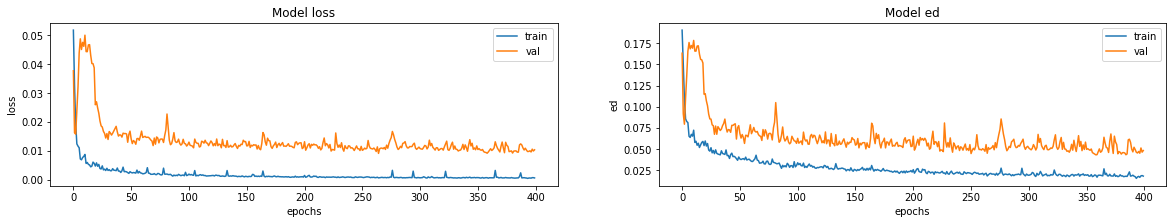

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["loss", "ed"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


# Inference

In [61]:
df = pd.read_csv("../split.csv")
df = df.loc[df['split']=="test"]
euc_dist = []
## keep only the test split 
for idx in df['ids']:
    study_path = f"../data/{idx}"
    if os.path.exists(os.path.join(study_path, "preop_ct.nii")):
        ct_path = os.path.join(study_path, "preop_ct.nii")
        nifti = nib.load(ct_path)
        nifti_data = np.nan_to_num(np.array(nifti.get_fdata()))
        ct_ex, label_ex, factors = process_study(study_path)
        #normlize
        label_ex = label_ex/60
        #### 
        model.load_weights("3d_image_classification.h5")
        prediction = model.predict(np.expand_dims(ct_ex, axis=0))[0]
        factors = 1/np.array(factors)
        label_ex[:,0]*=factors[0]
        label_ex[:,1]*=factors[1]
        label_ex[:,2]*=factors[2]
        prediction[:,0]*=factors[0]
        prediction[:,1]*=factors[1]
        prediction[:,2]*=factors[2]
        prediction *= 60
        label_ex *= 60
        euc_dist.append(euc_dist_tf(prediction, label_ex))

1/1 [==============================] - 0s 36ms/step


In [62]:
euc_dist = np.array(euc_dist)
mean = np.mean(euc_dist)
std = np.std(euc_dist)
print(f" {mean} +-  {std}")

 19.480904118377424 +-  21.673748507821674


Visualize last example

In [63]:
prediction

array([[ 55.78207 , 102.98968 ,  44.681812],
       [ 52.354675,  94.166565, 129.21172 ],
       [199.6153  , 115.4886  ,  45.466095],
       [202.85275 , 119.91403 , 130.5442  ]], dtype=float32)

In [64]:
label_ex

array([[ 61.,  79.,  50.],
       [ 61.,  86., 122.],
       [198., 109.,  39.],
       [201., 119., 133.]])

In [65]:
#Display the segmented features on CT volume
mlab.init_notebook()
fig = mlab.figure(bgcolor=(1, 1, 1), size=(500, 500))
source_1 = mlab.pipeline.scalar_field(nifti_data)
surface = mlab.pipeline.iso_surface(source_1, 
                         contours=[0.9,], 
                         opacity=0.5, 
                         colormap = 'black-white')
surface
mlab.points3d(prediction[:,0],prediction[:,1],prediction[:,2], color = (0.2,1,.2), scale_factor=10)
mlab.points3d(label_ex[:,0],label_ex[:,1],label_ex[:,2], color = (1,0,0), scale_factor=10)

Notebook initialized with ipy backend.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xf4\x00\x00\x01\xf4\x08\x02\x00\x00\x00D\xb4H\xd…